In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
print(preDouble)

\\iobsdc01\SharedDocs\SEER_MEDICARE\SEER_MEDICARE_STAGING


In [2]:
df = pd.read_pickle('dfpedsfFirsts.pickle')

## <font color='steelblue'>Description of the SEER-Medicare Data Files format</font>

Fixed width files. Data dictionary available to make the data not only machine readable but meaningful to humans

* Patient Entitlement and Diagnosis Summary File (PEDSF)
* Medicare Provider Analysis and Review (MEDPAR)
* Carrier Claims (old file name Physician/Supplier Part B (NCH))
* Outpatient Claims
* Home Health Agency (HAA)
* Hospice
* Durable Medical Equipment (DME)
* Medicare Part D Data

## <font color='steelblue'>First order of business is to identify all the patients in the SEER-Medicare data who have received PBT</font>

### <font color='steelblue'>Reminder:</font>

The relevant HCPCS are:

* 77520 - Proton trmt simple w/o comp
* 77522 - Proton trmt simple w/comp
* 77523 - Proton trmt intermediate
* 77525 - Proton treatment complex

as well as the HCPCS code S8030 (Scleral application of tantalum ring(s) for localization of lesions for proton beam therapy).

### <font color='steelblue'>Use the Outpatient Claims and Carrier Claims files</font>


* 218 Outpatient Claims files
* 207 Carrier Claims files


Loop through all of these files and capture the set of all the ```patient_id``` s corresponding to the PBT HCPCS codes

**Result: 1584 unique patients appear in the claims files for claims in years 2006-2013**


In [4]:
mask = (df['srvm1'] != 9999)
dfall = df[mask]

In [5]:
geomask = (dfall['elevation_1'] != dfall['FIPScombo_1']) 

dfall = dfall[geomask].copy()

In [6]:
dfall['elevation_1'].replace('99999',np.nan,inplace=True)
dfall['elevation_2'].replace('99999',np.nan,inplace=True)
dfall['elevation_3'].replace('99999',np.nan,inplace=True)

dfall['lat_1'].replace('99999',np.nan,inplace=True)
dfall['lat_2'].replace('99999',np.nan,inplace=True)
dfall['lat_3'].replace('99999',np.nan,inplace=True)

dfall['lng_1'].replace('99999',np.nan,inplace=True)
dfall['lng_2'].replace('99999',np.nan,inplace=True)
dfall['lng_3'].replace('99999',np.nan,inplace=True)

dfall['elevation_1'] = dfall['elevation_1'].astype('float')
dfall['elevation_2'] = dfall['elevation_2'].astype('float')
dfall['elevation_3'] = dfall['elevation_3'].astype('float')

dfall['lat_1'] = dfall['lat_1'].astype('float')
dfall['lat_2'] = dfall['lat_2'].astype('float')
dfall['lat_3'] = dfall['lat_3'].astype('float')

dfall['lng_1'] = dfall['lng_1'].astype('float')
dfall['lng_2'] = dfall['lng_2'].astype('float')
dfall['lng_3'] = dfall['lng_3'].astype('float')

In [8]:
import pickle
fileObject = open('patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_outsaf = list(set.union(*b))

In [9]:
import pickle
fileObject = open('patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_nch = list(set.union(*b))

In [10]:
bigtreatmentindices = list(set(treatmentindices_nch+treatmentindices_outsaf))

dfall.set_index('patient_id', inplace=True,drop=False)

allindices = dfall.index

In [11]:
bigtreatmentset = set(bigtreatmentindices)
allset = set(allindices)


alltreatmentindices = list(allset.intersection(bigtreatmentset))

treatmentindices = alltreatmentindices
#len(treatmentindices)

### <font color='steelblue'>Now use the pedsf files to perform patient matching, using the ```patient_id``` 's found above</font>

List of pedsf files (contains SEER cases for diagnosis year dates 2006-2011):

* pedsf.nasopharynx.cancer.txt
* pedsf.salivarygland.cancer.txt
* pedsf.oropharynx.cancer.txt
* pedsf.esophagus.cancer.txt
* pedsf.brain.cancer.txt
* pedsf.eyeandorbit.cancer.txt
* pedsf.softtissue.cancer.txt
* pedsf.prostate.cancer.file01.txt
* pedsf.prostate.cancer.file02.txt
* pedsf.prostate.cancer.file03.txt
* pedsf.lung.cancer.file01.txt
* pedsf.lung.cancer.file02.txt



### <font color='steelblue'>The pedsf files contain one single row for each patient, and contain the information for up to 10 different primary tumors.</font>

So the prostate cancer files contain all patients with a cancer diagnosis where the primary site is the prostate for ANY of the potentially 10 different primary tumors associated with that patient and where that prostate site tumor has a diagnosis date anywhere between 2006 and 2011.

 

In [12]:
import pedsfhelp

df2 = pedsfhelp.make_clean_dataframe('pedsf.salivarygland.cancer.txt')
#print(df2.shape)

For example, in the ```pedsf.salivarygland.cancer.txt```, the cancer sites for the first tumor listed for each patient has the following distribution:

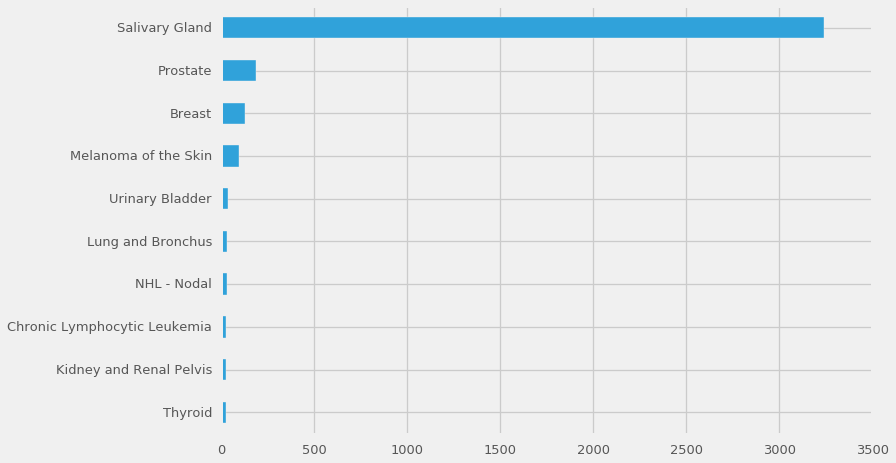

In [21]:
df2.siterwho1.value_counts()[:10][::-1].plot(kind='barh');